In [1]:
# ----------------------------
#TRAINING
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import os
from PIL import Image

# ----------------------------
# Parameters
# ----------------------------
data_dir = 'dataset/'
num_classes = 10 
batch_size = 16
num_epochs = 10
learning_rate = 0.001
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------

class AmharicDataset(Dataset):
    def __init__(self, folder):
        self.samples = []
        self.labels = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(folder))):
            class_path = os.path.join(folder, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for file_name in os.listdir(class_path):
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        self.samples.append(os.path.join(class_path, file_name))
                        self.labels.append(idx)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')  # grayscale
        img = img.resize((128, 128))
        img = np.array(img, dtype=np.float32) / 255.0  # normalize
        img = np.stack([img]*3, axis=0)  # 3 channels
        img = torch.tensor(img)
        return img, label

# ----------------------------
# Load Datasets
# ----------------------------
train_dataset = AmharicDataset(os.path.join(data_dir, 'train'))
val_dataset = AmharicDataset(os.path.join(data_dir, 'val'))
test_dataset = AmharicDataset(os.path.join(data_dir, 'test'))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# Simple CNN Model
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)

# ----------------------------
# Loss and Optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ----------------------------
# Training Function (with metrics)
# ----------------------------
def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered.')
                break

    return train_losses, val_losses, train_accs, val_accs

# ----------------------------
# Train the model
# ----------------------------
train_losses, val_losses, train_accs, val_accs = train_model_with_metrics(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience
)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/10 | Train Loss: 0.6558, Train Acc: 0.7804 | Val Loss: 0.2138, Val Acc: 0.9314
Epoch 2/10 | Train Loss: 0.2476, Train Acc: 0.9168 | Val Loss: 0.1422, Val Acc: 0.9544
Epoch 3/10 | Train Loss: 0.1529, Train Acc: 0.9496 | Val Loss: 0.0867, Val Acc: 0.9740
Epoch 4/10 | Train Loss: 0.1097, Train Acc: 0.9640 | Val Loss: 0.0983, Val Acc: 0.9722
Epoch 5/10 | Train Loss: 0.0880, Train Acc: 0.9693 | Val Loss: 0.0691, Val Acc: 0.9834
Epoch 6/10 | Train Loss: 0.0769, Train Acc: 0.9743 | Val Loss: 0.0785, Val Acc: 0.9781
Epoch 7/10 | Train Loss: 0.0599, Train Acc: 0.9791 | Val Loss: 0.0904, Val Acc: 0.9763
Epoch 8/10 | Train Loss: 0.0575, Train Acc: 0.9801 | Val Loss: 0.0659, Val Acc: 0.9852
Epoch 9/10 | Train Loss: 0.0443, Train Acc: 0.9850 | Val Loss: 0.0643, Val Acc: 0.9855
Epoch 10/10 | Train Loss: 0.0427, Train Acc: 0.9856 | Val Loss: 0.0729, Val Acc: 0.9814


<All keys matched successfully>

Classification Report:
              precision    recall  f1-score   support

          be       0.98      1.00      0.99       404
          ha       0.98      0.99      0.99       371
         hha       1.00      0.98      0.99       306
          le       0.95      0.99      0.97       369
          me       0.99      0.99      0.99       293
          qe       0.99      0.99      0.99       368
          re       0.99      0.99      0.99       299
          sa       0.98      0.95      0.97       372
          se       0.99      0.99      0.99       305
         sha       1.00      0.98      0.99       308

    accuracy                           0.98      3395
   macro avg       0.99      0.98      0.98      3395
weighted avg       0.98      0.98      0.98      3395



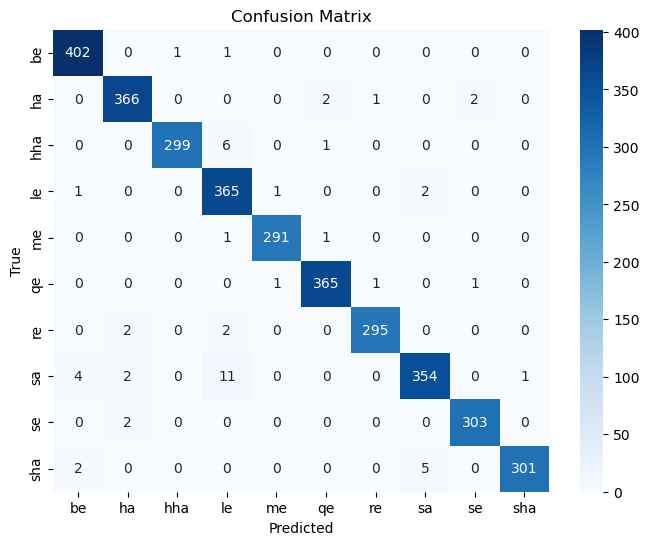

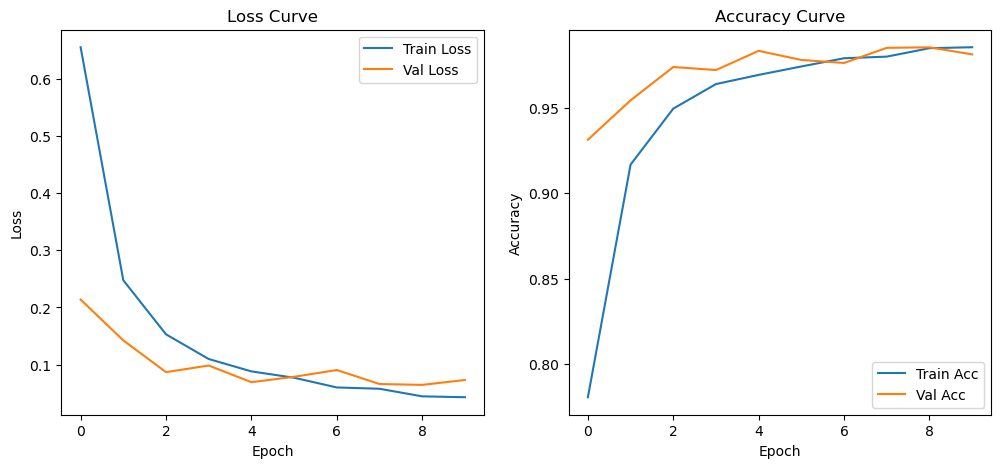

Predicted class: be


In [2]:
# ----------------------------
# EVALUATION & SINGLE IMAGE TEST
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image

# ----------------------------
# Confusion Matrix & Report
# ----------------------------
model.eval()
preds, trues = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        trues.extend(labels.cpu().numpy())

class_names = sorted(train_dataset.class_to_idx.keys())

# Classification report
print("Classification Report:")
print(classification_report(trues, preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ----------------------------
# Plot Loss & Accuracy Curves
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# ----------------------------
# Single Image Prediction
# ----------------------------
def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert('L').resize((128,128))
    img = np.array(img, dtype=np.float32)/255.0
    img = np.stack([img]*3, axis=0)
    img = torch.tensor(img).unsqueeze(0).to(device)  # batch dimension

    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    print(f"Predicted class: {class_names[pred.item()]}")

# Example usage:
predict_image(model, 'dataset/test/be/dataset0_form1_7956_bold.png')
